# Деревья решений
Оригинал: https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_russian/topic03_decision_trees_knn/lesson3_practice_trees_titanic.ipynb

Загрузим библиотеки

In [1]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install sklearn


In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import scipy
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc
%matplotlib inline

data_o = pd.read_csv('boston_crime.csv', sep=',')

def shoot_nans(value):
    if value == 'Y':
        return 1
    if pd.isnull(value):
        return 0

for col in ['SHOOTING']:
    data_o[col] = data_o[col].apply(shoot_nans)
    
data_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411033 entries, 0 to 411032
Data columns (total 17 columns):
INCIDENT_NUMBER        411033 non-null object
OFFENSE_CODE           411033 non-null int64
OFFENSE_CODE_GROUP     411033 non-null object
OFFENSE_DESCRIPTION    411033 non-null object
DISTRICT               408902 non-null object
REPORTING_AREA         411033 non-null object
SHOOTING               411033 non-null int64
OCCURRED_ON_DATE       411033 non-null object
YEAR                   411033 non-null int64
MONTH                  411033 non-null int64
DAY_OF_WEEK            411033 non-null object
HOUR                   411033 non-null int64
UCR_PART               410924 non-null object
STREET                 398927 non-null object
Lat                    384797 non-null float64
Long                   384797 non-null float64
Location               411033 non-null object
dtypes: float64(2), int64(5), object(10)
memory usage: 53.3+ MB


In [2]:
def dropper(X):
    if 'STREET' in X.columns:
        X = X.drop(['INCIDENT_NUMBER', 'REPORTING_AREA', 'OFFENSE_CODE_GROUP','YEAR', 'MONTH', 'HOUR', 'UCR_PART',
                     'OFFENSE_DESCRIPTION', 'STREET', 'OFFENSE_CODE'],
                     axis='columns')
    return X

def other_transformations(X):
    def dig(s):
        n = ['1','2','3','4','5','6','7','8','9','0']
        if pd.isnull(s):
            return 0
        else:            
            s_int = ''
            for i in range(len(s)):
                if s[i] in n:
                    s_int += s[i]
        return int(s_int)

    def distr_nans(value):
        sec = {
            'A': 1,
            'B': 2,
            'C': 3,
            'D': 4,
            'E': 5,
        }
        if pd.isnull(value):
            return 0
        else: 
            if isinstance(value, str):
                return sec[value[0]]

    def loc_nans(value):
        if pd.isnull(value):
            return 0
        else:
            return value*1000000

    def week (value):
        weekdays = {
            'Monday' : 1,
            'Tuesday' : 2,
            'Wednesday' : 3, 
            'Thursday' : 4, 
            'Friday' : 5, 
            'Saturday' : 6, 
            'Sunday' : 7
        }
        return weekdays[value]
    
    def datef (value):
        return pd.Timestamp(ts_input = value).timestamp()
    
    if 'DISTRICT' in X.columns:
        for col in ['DISTRICT']:
            X['Location'] = X[col].apply(dig)
            X[col]=X[col].apply(distr_nans)
    if 'OCCURRED_ON_DATE' in X.columns:
        for col in ['OCCURRED_ON_DATE']:
            X[col]=X[col].apply(datef)
    if 'Lat' in X.columns:        
        for col in ['Lat', 'Long']:
            X[col]=X[col].apply(loc_nans)
    #if 'SHOOTING' in X.columns:
    #    for col in ['SHOOTING']:
    #        X[col] = X[col].apply(shoot_nans)
    if 'DAY_OF_WEEK' in X.columns:
        X['DAY_OF_WEEK'] = X['DAY_OF_WEEK'].apply(week)
    return X

def norm(X_train, X_test, y_train):
    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train, ), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)
    X_train_scaled.reset_index(inplace=True, drop=True)
    y_train.reset_index(drop=True, inplace=True)
    dead = X_train_scaled[y_train == 1]
    for i in range (7):
        dead = pd.concat([dead,dead], ignore_index=True)
    X_train_strat = pd.concat([X_train_scaled, dead], ignore_index=True)
    y_train_strat = pd.concat([y_train, pd.Series(np.ones(X_train_strat.shape[0]-X_train_scaled.shape[0]))],
                              ignore_index=True)
    return X_train_strat, X_test_scaled, y_train_strat

data = dropper(data_o)
data = other_transformations(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411033 entries, 0 to 411032
Data columns (total 7 columns):
DISTRICT            411033 non-null int64
SHOOTING            411033 non-null int64
OCCURRED_ON_DATE    411033 non-null float64
DAY_OF_WEEK         411033 non-null int64
Lat                 411033 non-null float64
Long                411033 non-null float64
Location            411033 non-null int64
dtypes: float64(3), int64(4)
memory usage: 22.0 MB


In [3]:
X = data.drop('SHOOTING', axis='columns')
y = data['SHOOTING']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   test_size = 0.33, stratify=y)

In [4]:
X_train, X_test, y_train = norm(X_train, X_test, y_train)

In [6]:
# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=50, random_state=50, min_samples_leaf = 1)
clf_tree.fit(X_train, y_train)
a = clf_tree.predict(X_test)
b = clf_tree.predict_proba(X_test)

print('Accuracy:', accuracy_score(y_test, a))
print('Precision:', precision_score(y_test, a))           
print('Recall:', recall_score(y_test, a))
print('ROC AUC:', roc_auc_score(y_test, a))
pr, rec, _ = precision_recall_curve(y_test, a)
print('PRC AUC:', auc(rec, pr))
print('F1:', f1_score(y_test, a))
print('F0.5:', fbeta_score(y_test, a, 0.5))
print('F2:', fbeta_score(y_test, a, 2))

Accuracy: 0.9962548197079054
Precision: 0.5356083086053413
Recall: 0.6492805755395683
ROC AUC: 0.8234817579552229
PRC AUC: 0.5931632512820595
F1: 0.5869918699186991
F0.5: 0.5550430504305043
F2: 0.6228433402346445


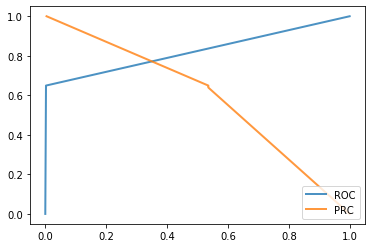

In [7]:
fpr, tpr, thresholds = roc_curve(y_test,b[:,1])
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_test, b[:,1])
#pr_auc = auc(precision, recall)
plt.plot(fpr, tpr, lw=2, alpha=0.8,
             label='ROC')
plt.plot(precision, recall, lw=2, alpha=0.8,
             label='PRC')
plt.legend(loc="lower right")

In [8]:
dtree = DecisionTreeRegressor().fit(X_train, y_train)
a = dtree.predict(X_test)

In [9]:
print('Accuracy:', accuracy_score(y_test, a.round()))
print('Precision:', precision_score(y_test, a.round()))           
print('Recall:', recall_score(y_test, a.round()))
print('ROC AUC:', roc_auc_score(y_test, a.round()))
pr, rec, _ = precision_recall_curve(y_test, a.round())
print('PRC AUC:', auc(rec, pr))
print('F1:', f1_score(y_test, a.round()))
print('F0.5:', fbeta_score(y_test, a.round(), 0.5))
print('F2:', fbeta_score(y_test, a.round(), 2))

Accuracy: 0.9964317573595004
Precision: 0.5560747663551402
Recall: 0.6420863309352518
ROC AUC: 0.8199882741029296
PRC AUC: 0.5998141026591004
F1: 0.5959933222036727
F0.5: 0.571382842509603
F2: 0.6228192602930914


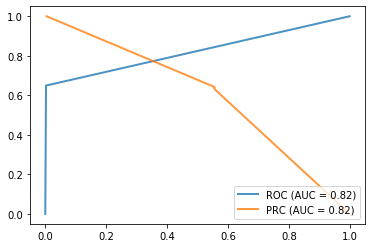

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, b[:,1])
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_test, a)
#pr_auc = auc(precision, recall)
plt.plot(fpr, tpr, lw=2, alpha=0.8,
             label='ROC (AUC = %0.2f)' % (roc_auc))
plt.plot(precision, recall, lw=2, alpha=0.8,
             label='PRC (AUC = %0.2f)' % (roc_auc))
plt.legend(loc="lower right")

In [11]:
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
a = rf.predict(X_test)

In [12]:
rf.feature_importances_

array([0.00525724, 0.3245162 , 0.075428  , 0.3068875 , 0.28111314,
       0.00679793])

In [13]:
print('Accuracy:', accuracy_score(y_test, a.round()))
print('Precision:', precision_score(y_test, a.round()))           
print('Recall:', recall_score(y_test, a.round()))
print('ROC AUC:', roc_auc_score(y_test, a.round()))
pr, rec, _ = precision_recall_curve(y_test, a.round())
print('PRC AUC:', auc(rec, pr))
print('F1:', f1_score(y_test, a.round()))
print('F0.5:', fbeta_score(y_test, a.round(), 0.5))
print('F2:', fbeta_score(y_test, a.round(), 2))

Accuracy: 0.9972427215959776
Precision: 0.6710526315789473
Recall: 0.6420863309352518
ROC AUC: 0.8203954251559703
PRC AUC: 0.657303035271004
F1: 0.65625
F0.5: 0.6650521609538003
F2: 0.6476777939042091


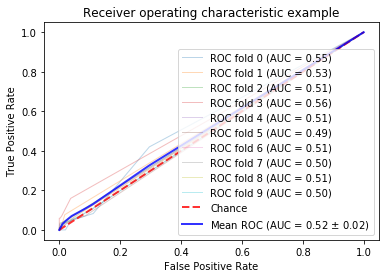

In [15]:
cv = StratifiedKFold(n_splits=10, random_state=1)
clf = RandomForestClassifier(random_state = 1)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X = data.drop('SHOOTING', axis='columns')
y = data['SHOOTING']
i = 0

for train, test in cv.split(X, y):
    probas_ = clf.fit(X.iloc[train], y[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [6]:
%%time

from catboost import CatBoostRegressor
import numpy as np
from sklearn.metrics import mean_squared_error

scores = np.ndarray([13, 13])
for i, n_trees in enumerate(np.arange(100, 250, 11)):
    for j, depth in enumerate(np.arange(2, 15)):
        p = CatBoostClassifier(n_estimators=n_trees, max_depth=depth, task_type="GPU").fit(X_train, y_train).predict(X_test)
        scores[i, j] = mean_squared_error(y_test, p)

ModuleNotFoundError: No module named 'catboost'

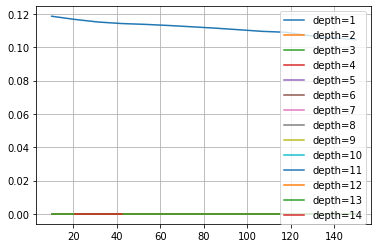

In [49]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

for i in range(scores.shape[0]):
    plt.plot(np.linspace(10, 150, 14), scores[i], label='depth=' + str(np.arange(1, 15)[i]))
plt.grid(True)
plt.legend()

In [ ]:
for i in range(scores.shape[1]):
    plt.plot(np.arange(1, 15), scores[i], label='trees=' + str(np.linspace(10, 150, 14)[i]))
plt.legend()

In [19]:
%%time

from catboost import CatBoostRegressor
import numpy as np
from sklearn.metrics import mean_squared_error

scores = np.ndarray([10, 10])
for i, n_trees in enumerate(np.linspace(1, 100, 10)):
    for j, depth in enumerate(np.arange(2, 12)):
        p = CatBoostRegressor(n_estimators=n_trees, max_depth=depth, task_type="CPU").fit(X_train, y_train).predict(X_test)
        scores[i, j] = mean_squared_error(y_test, p)

0:	learn: 0.4745684	total: 34.7ms	remaining: 0us
0:	learn: 0.4742221	total: 15.7ms	remaining: 0us
0:	learn: 0.4739200	total: 16ms	remaining: 0us
0:	learn: 0.4736883	total: 15.9ms	remaining: 0us
0:	learn: 0.4736037	total: 24.9ms	remaining: 0us
0:	learn: 0.4734252	total: 25.2ms	remaining: 0us
0:	learn: 0.4732224	total: 25.3ms	remaining: 0us
0:	learn: 0.4729838	total: 28.7ms	remaining: 0us
0:	learn: 0.4727514	total: 33.7ms	remaining: 0us
0:	learn: 0.4724262	total: 47.5ms	remaining: 0us
0:	learn: 0.4745684	total: 12.2ms	remaining: 134ms
1:	learn: 0.4731585	total: 23.7ms	remaining: 119ms
2:	learn: 0.4718132	total: 34.9ms	remaining: 105ms
3:	learn: 0.4705368	total: 45.9ms	remaining: 91.8ms
4:	learn: 0.4693259	total: 57.3ms	remaining: 80.2ms
5:	learn: 0.4681432	total: 68.5ms	remaining: 68.5ms
6:	learn: 0.4670277	total: 79.5ms	remaining: 56.8ms
7:	learn: 0.4659765	total: 91.8ms	remaining: 45.9ms
8:	learn: 0.4649564	total: 102ms	remaining: 34.2ms
9:	learn: 0.4639831	total: 113ms	remaining: 22.7

15:	learn: 0.4539836	total: 228ms	remaining: 99.7ms
16:	learn: 0.4531424	total: 242ms	remaining: 85.4ms
17:	learn: 0.4522782	total: 256ms	remaining: 71ms
18:	learn: 0.4514021	total: 270ms	remaining: 56.8ms
19:	learn: 0.4506316	total: 282ms	remaining: 42.2ms
20:	learn: 0.4499164	total: 294ms	remaining: 28ms
21:	learn: 0.4491462	total: 306ms	remaining: 13.9ms
22:	learn: 0.4484910	total: 319ms	remaining: 0us
0:	learn: 0.4739200	total: 17.8ms	remaining: 392ms
1:	learn: 0.4717553	total: 32.3ms	remaining: 339ms
2:	learn: 0.4697193	total: 46.1ms	remaining: 308ms
3:	learn: 0.4677804	total: 60.7ms	remaining: 288ms
4:	learn: 0.4660543	total: 74.5ms	remaining: 268ms
5:	learn: 0.4644122	total: 88.3ms	remaining: 250ms
6:	learn: 0.4627331	total: 102ms	remaining: 233ms
7:	learn: 0.4612660	total: 116ms	remaining: 217ms
8:	learn: 0.4597843	total: 129ms	remaining: 201ms
9:	learn: 0.4583649	total: 143ms	remaining: 186ms
10:	learn: 0.4571047	total: 158ms	remaining: 172ms
11:	learn: 0.4559434	total: 173ms	

21:	learn: 0.4269833	total: 683ms	remaining: 31ms
22:	learn: 0.4255073	total: 713ms	remaining: 0us
0:	learn: 0.4724262	total: 38.5ms	remaining: 848ms
1:	learn: 0.4689812	total: 75.6ms	remaining: 794ms
2:	learn: 0.4657101	total: 112ms	remaining: 748ms
3:	learn: 0.4623750	total: 150ms	remaining: 713ms
4:	learn: 0.4592202	total: 188ms	remaining: 677ms
5:	learn: 0.4564736	total: 225ms	remaining: 639ms
6:	learn: 0.4535087	total: 267ms	remaining: 610ms
7:	learn: 0.4509359	total: 305ms	remaining: 572ms
8:	learn: 0.4486595	total: 341ms	remaining: 530ms
9:	learn: 0.4459573	total: 377ms	remaining: 490ms
10:	learn: 0.4433459	total: 414ms	remaining: 451ms
11:	learn: 0.4408420	total: 452ms	remaining: 414ms
12:	learn: 0.4385054	total: 492ms	remaining: 378ms
13:	learn: 0.4361693	total: 529ms	remaining: 340ms
14:	learn: 0.4340194	total: 567ms	remaining: 302ms
15:	learn: 0.4320197	total: 604ms	remaining: 264ms
16:	learn: 0.4301056	total: 641ms	remaining: 226ms
17:	learn: 0.4281276	total: 676ms	remainin

0:	learn: 0.4736037	total: 22.9ms	remaining: 754ms
1:	learn: 0.4712040	total: 43.1ms	remaining: 690ms
2:	learn: 0.4689622	total: 64.3ms	remaining: 665ms
3:	learn: 0.4667843	total: 84.9ms	remaining: 637ms
4:	learn: 0.4647231	total: 105ms	remaining: 608ms
5:	learn: 0.4627585	total: 124ms	remaining: 581ms
6:	learn: 0.4609277	total: 145ms	remaining: 558ms
7:	learn: 0.4591535	total: 168ms	remaining: 545ms
8:	learn: 0.4575492	total: 189ms	remaining: 524ms
9:	learn: 0.4559728	total: 209ms	remaining: 501ms
10:	learn: 0.4544664	total: 228ms	remaining: 477ms
11:	learn: 0.4529783	total: 250ms	remaining: 459ms
12:	learn: 0.4515669	total: 273ms	remaining: 442ms
13:	learn: 0.4502801	total: 292ms	remaining: 418ms
14:	learn: 0.4491015	total: 313ms	remaining: 397ms
15:	learn: 0.4479064	total: 332ms	remaining: 374ms
16:	learn: 0.4467292	total: 351ms	remaining: 351ms
17:	learn: 0.4456300	total: 372ms	remaining: 331ms
18:	learn: 0.4445595	total: 391ms	remaining: 308ms
19:	learn: 0.4435782	total: 410ms	rem

27:	learn: 0.4193729	total: 931ms	remaining: 199ms
28:	learn: 0.4179786	total: 965ms	remaining: 166ms
29:	learn: 0.4169953	total: 995ms	remaining: 133ms
30:	learn: 0.4159179	total: 1.02s	remaining: 99.1ms
31:	learn: 0.4148856	total: 1.05s	remaining: 65.9ms
32:	learn: 0.4138949	total: 1.08s	remaining: 32.8ms
33:	learn: 0.4128964	total: 1.11s	remaining: 0us
0:	learn: 0.4724262	total: 37.2ms	remaining: 1.23s
1:	learn: 0.4689812	total: 75.7ms	remaining: 1.21s
2:	learn: 0.4657101	total: 111ms	remaining: 1.15s
3:	learn: 0.4623750	total: 148ms	remaining: 1.11s
4:	learn: 0.4592202	total: 185ms	remaining: 1.07s
5:	learn: 0.4564736	total: 222ms	remaining: 1.04s
6:	learn: 0.4535087	total: 263ms	remaining: 1.01s
7:	learn: 0.4509359	total: 299ms	remaining: 972ms
8:	learn: 0.4486595	total: 335ms	remaining: 931ms
9:	learn: 0.4459573	total: 371ms	remaining: 891ms
10:	learn: 0.4433459	total: 410ms	remaining: 857ms
11:	learn: 0.4408420	total: 445ms	remaining: 817ms
12:	learn: 0.4385054	total: 484ms	rema

43:	learn: 0.4355722	total: 648ms	remaining: 14.7ms
44:	learn: 0.4352806	total: 666ms	remaining: 0us
0:	learn: 0.4736883	total: 21.9ms	remaining: 963ms
1:	learn: 0.4714153	total: 38.6ms	remaining: 830ms
2:	learn: 0.4692789	total: 54.4ms	remaining: 762ms
3:	learn: 0.4672604	total: 69.9ms	remaining: 717ms
4:	learn: 0.4653122	total: 85.5ms	remaining: 684ms
5:	learn: 0.4634930	total: 101ms	remaining: 656ms
6:	learn: 0.4617801	total: 118ms	remaining: 643ms
7:	learn: 0.4601177	total: 134ms	remaining: 619ms
8:	learn: 0.4585597	total: 149ms	remaining: 598ms
9:	learn: 0.4570982	total: 165ms	remaining: 577ms
10:	learn: 0.4556960	total: 180ms	remaining: 557ms
11:	learn: 0.4543603	total: 196ms	remaining: 539ms
12:	learn: 0.4531398	total: 213ms	remaining: 523ms
13:	learn: 0.4519932	total: 232ms	remaining: 513ms
14:	learn: 0.4509164	total: 247ms	remaining: 495ms
15:	learn: 0.4498841	total: 263ms	remaining: 477ms
16:	learn: 0.4488319	total: 279ms	remaining: 460ms
17:	learn: 0.4478201	total: 296ms	rem

26:	learn: 0.4298232	total: 675ms	remaining: 450ms
27:	learn: 0.4287067	total: 700ms	remaining: 425ms
28:	learn: 0.4276675	total: 728ms	remaining: 402ms
29:	learn: 0.4267321	total: 753ms	remaining: 376ms
30:	learn: 0.4258362	total: 782ms	remaining: 353ms
31:	learn: 0.4250669	total: 812ms	remaining: 330ms
32:	learn: 0.4241562	total: 840ms	remaining: 306ms
33:	learn: 0.4234177	total: 871ms	remaining: 282ms
34:	learn: 0.4226848	total: 902ms	remaining: 258ms
35:	learn: 0.4217965	total: 932ms	remaining: 233ms
36:	learn: 0.4211134	total: 960ms	remaining: 208ms
37:	learn: 0.4203877	total: 985ms	remaining: 181ms
38:	learn: 0.4197791	total: 1.01s	remaining: 155ms
39:	learn: 0.4189945	total: 1.04s	remaining: 130ms
40:	learn: 0.4183768	total: 1.06s	remaining: 104ms
41:	learn: 0.4178033	total: 1.09s	remaining: 77.7ms
42:	learn: 0.4170826	total: 1.11s	remaining: 51.8ms
43:	learn: 0.4164812	total: 1.14s	remaining: 26ms
44:	learn: 0.4160309	total: 1.17s	remaining: 0us
0:	learn: 0.4729838	total: 45.1m

18:	learn: 0.4569566	total: 214ms	remaining: 417ms
19:	learn: 0.4563303	total: 227ms	remaining: 408ms
20:	learn: 0.4557214	total: 239ms	remaining: 399ms
21:	learn: 0.4549874	total: 252ms	remaining: 389ms
22:	learn: 0.4543863	total: 263ms	remaining: 377ms
23:	learn: 0.4537154	total: 275ms	remaining: 366ms
24:	learn: 0.4530798	total: 287ms	remaining: 356ms
25:	learn: 0.4524802	total: 299ms	remaining: 345ms
26:	learn: 0.4519633	total: 311ms	remaining: 334ms
27:	learn: 0.4514291	total: 325ms	remaining: 325ms
28:	learn: 0.4509588	total: 338ms	remaining: 314ms
29:	learn: 0.4504477	total: 351ms	remaining: 304ms
30:	learn: 0.4500090	total: 363ms	remaining: 293ms
31:	learn: 0.4495350	total: 375ms	remaining: 281ms
32:	learn: 0.4491086	total: 388ms	remaining: 270ms
33:	learn: 0.4486746	total: 401ms	remaining: 259ms
34:	learn: 0.4482777	total: 412ms	remaining: 247ms
35:	learn: 0.4478696	total: 425ms	remaining: 236ms
36:	learn: 0.4475103	total: 441ms	remaining: 226ms
37:	learn: 0.4471565	total: 454

12:	learn: 0.4531398	total: 222ms	remaining: 734ms
13:	learn: 0.4519932	total: 243ms	remaining: 730ms
14:	learn: 0.4509164	total: 261ms	remaining: 713ms
15:	learn: 0.4498841	total: 282ms	remaining: 705ms
16:	learn: 0.4488319	total: 299ms	remaining: 687ms
17:	learn: 0.4478201	total: 319ms	remaining: 672ms
18:	learn: 0.4468778	total: 336ms	remaining: 655ms
19:	learn: 0.4460146	total: 355ms	remaining: 639ms
20:	learn: 0.4451052	total: 372ms	remaining: 620ms
21:	learn: 0.4442974	total: 389ms	remaining: 601ms
22:	learn: 0.4434437	total: 407ms	remaining: 583ms
23:	learn: 0.4426293	total: 425ms	remaining: 567ms
24:	learn: 0.4418428	total: 446ms	remaining: 553ms
25:	learn: 0.4411714	total: 464ms	remaining: 536ms
26:	learn: 0.4405350	total: 484ms	remaining: 520ms
27:	learn: 0.4398823	total: 502ms	remaining: 502ms
28:	learn: 0.4392239	total: 520ms	remaining: 485ms
29:	learn: 0.4385870	total: 537ms	remaining: 466ms
30:	learn: 0.4380438	total: 555ms	remaining: 448ms
31:	learn: 0.4374954	total: 572

9:	learn: 0.4522631	total: 244ms	remaining: 1.12s
10:	learn: 0.4503969	total: 265ms	remaining: 1.09s
11:	learn: 0.4486084	total: 288ms	remaining: 1.05s
12:	learn: 0.4468657	total: 314ms	remaining: 1.04s
13:	learn: 0.4453873	total: 337ms	remaining: 1.01s
14:	learn: 0.4438991	total: 362ms	remaining: 988ms
15:	learn: 0.4425721	total: 385ms	remaining: 962ms
16:	learn: 0.4411182	total: 411ms	remaining: 943ms
17:	learn: 0.4398433	total: 436ms	remaining: 920ms
18:	learn: 0.4386407	total: 464ms	remaining: 903ms
19:	learn: 0.4372108	total: 494ms	remaining: 889ms
20:	learn: 0.4360178	total: 519ms	remaining: 864ms
21:	learn: 0.4348714	total: 542ms	remaining: 837ms
22:	learn: 0.4338455	total: 564ms	remaining: 809ms
23:	learn: 0.4327053	total: 587ms	remaining: 783ms
24:	learn: 0.4316542	total: 612ms	remaining: 759ms
25:	learn: 0.4307376	total: 637ms	remaining: 735ms
26:	learn: 0.4298232	total: 664ms	remaining: 713ms
27:	learn: 0.4287067	total: 690ms	remaining: 690ms
28:	learn: 0.4276675	total: 715m

6:	learn: 0.4535087	total: 272ms	remaining: 1.91s
7:	learn: 0.4509359	total: 312ms	remaining: 1.87s
8:	learn: 0.4486595	total: 354ms	remaining: 1.85s
9:	learn: 0.4459573	total: 398ms	remaining: 1.83s
10:	learn: 0.4433459	total: 442ms	remaining: 1.81s
11:	learn: 0.4408420	total: 490ms	remaining: 1.8s
12:	learn: 0.4385054	total: 531ms	remaining: 1.76s
13:	learn: 0.4361693	total: 570ms	remaining: 1.71s
14:	learn: 0.4340194	total: 611ms	remaining: 1.67s
15:	learn: 0.4320197	total: 653ms	remaining: 1.63s
16:	learn: 0.4301056	total: 699ms	remaining: 1.6s
17:	learn: 0.4281276	total: 740ms	remaining: 1.56s
18:	learn: 0.4262110	total: 782ms	remaining: 1.52s
19:	learn: 0.4246437	total: 824ms	remaining: 1.48s
20:	learn: 0.4229608	total: 869ms	remaining: 1.45s
21:	learn: 0.4213295	total: 911ms	remaining: 1.41s
22:	learn: 0.4198831	total: 951ms	remaining: 1.36s
23:	learn: 0.4184841	total: 987ms	remaining: 1.31s
24:	learn: 0.4171118	total: 1.02s	remaining: 1.27s
25:	learn: 0.4157601	total: 1.06s	rem

47:	learn: 0.4378698	total: 640ms	remaining: 253ms
48:	learn: 0.4376222	total: 653ms	remaining: 240ms
49:	learn: 0.4373830	total: 666ms	remaining: 227ms
50:	learn: 0.4371350	total: 680ms	remaining: 213ms
51:	learn: 0.4368961	total: 692ms	remaining: 200ms
52:	learn: 0.4366834	total: 706ms	remaining: 186ms
53:	learn: 0.4364673	total: 718ms	remaining: 173ms
54:	learn: 0.4362578	total: 731ms	remaining: 159ms
55:	learn: 0.4360532	total: 745ms	remaining: 146ms
56:	learn: 0.4358666	total: 758ms	remaining: 133ms
57:	learn: 0.4356731	total: 771ms	remaining: 120ms
58:	learn: 0.4354799	total: 783ms	remaining: 106ms
59:	learn: 0.4353018	total: 796ms	remaining: 92.8ms
60:	learn: 0.4351325	total: 809ms	remaining: 79.5ms
61:	learn: 0.4349731	total: 822ms	remaining: 66.3ms
62:	learn: 0.4347776	total: 836ms	remaining: 53.1ms
63:	learn: 0.4346199	total: 851ms	remaining: 39.9ms
64:	learn: 0.4344440	total: 864ms	remaining: 26.6ms
65:	learn: 0.4342850	total: 877ms	remaining: 13.3ms
66:	learn: 0.4341223	tot

12:	learn: 0.4515669	total: 242ms	remaining: 1.01s
13:	learn: 0.4502801	total: 259ms	remaining: 982ms
14:	learn: 0.4491015	total: 277ms	remaining: 960ms
15:	learn: 0.4479064	total: 296ms	remaining: 942ms
16:	learn: 0.4467292	total: 314ms	remaining: 923ms
17:	learn: 0.4456300	total: 334ms	remaining: 908ms
18:	learn: 0.4445595	total: 352ms	remaining: 890ms
19:	learn: 0.4435782	total: 370ms	remaining: 869ms
20:	learn: 0.4426096	total: 388ms	remaining: 849ms
21:	learn: 0.4416081	total: 406ms	remaining: 830ms
22:	learn: 0.4408048	total: 424ms	remaining: 812ms
23:	learn: 0.4399524	total: 444ms	remaining: 795ms
24:	learn: 0.4390813	total: 461ms	remaining: 775ms
25:	learn: 0.4381811	total: 479ms	remaining: 756ms
26:	learn: 0.4374300	total: 497ms	remaining: 737ms
27:	learn: 0.4366269	total: 515ms	remaining: 717ms
28:	learn: 0.4358616	total: 534ms	remaining: 700ms
29:	learn: 0.4350769	total: 554ms	remaining: 683ms
30:	learn: 0.4343435	total: 571ms	remaining: 663ms
31:	learn: 0.4336753	total: 590

45:	learn: 0.4155042	total: 1.05s	remaining: 482ms
46:	learn: 0.4147641	total: 1.08s	remaining: 459ms
47:	learn: 0.4141627	total: 1.1s	remaining: 436ms
48:	learn: 0.4136422	total: 1.13s	remaining: 414ms
49:	learn: 0.4129697	total: 1.15s	remaining: 391ms
50:	learn: 0.4124590	total: 1.17s	remaining: 369ms
51:	learn: 0.4118406	total: 1.2s	remaining: 345ms
52:	learn: 0.4113434	total: 1.22s	remaining: 323ms
53:	learn: 0.4107852	total: 1.25s	remaining: 300ms
54:	learn: 0.4103404	total: 1.27s	remaining: 277ms
55:	learn: 0.4098577	total: 1.29s	remaining: 254ms
56:	learn: 0.4093834	total: 1.32s	remaining: 231ms
57:	learn: 0.4089624	total: 1.34s	remaining: 208ms
58:	learn: 0.4085152	total: 1.36s	remaining: 185ms
59:	learn: 0.4081105	total: 1.39s	remaining: 162ms
60:	learn: 0.4077324	total: 1.41s	remaining: 139ms
61:	learn: 0.4073434	total: 1.44s	remaining: 116ms
62:	learn: 0.4069333	total: 1.46s	remaining: 92.6ms
63:	learn: 0.4066089	total: 1.48s	remaining: 69.4ms
64:	learn: 0.4062113	total: 1.5

11:	learn: 0.4408420	total: 496ms	remaining: 2.27s
12:	learn: 0.4385054	total: 536ms	remaining: 2.23s
13:	learn: 0.4361693	total: 573ms	remaining: 2.17s
14:	learn: 0.4340194	total: 611ms	remaining: 2.12s
15:	learn: 0.4320197	total: 648ms	remaining: 2.06s
16:	learn: 0.4301056	total: 688ms	remaining: 2.02s
17:	learn: 0.4281276	total: 736ms	remaining: 2s
18:	learn: 0.4262110	total: 783ms	remaining: 1.98s
19:	learn: 0.4246437	total: 822ms	remaining: 1.93s
20:	learn: 0.4229608	total: 865ms	remaining: 1.89s
21:	learn: 0.4213295	total: 911ms	remaining: 1.86s
22:	learn: 0.4198831	total: 950ms	remaining: 1.82s
23:	learn: 0.4184841	total: 989ms	remaining: 1.77s
24:	learn: 0.4171118	total: 1.02s	remaining: 1.72s
25:	learn: 0.4157601	total: 1.06s	remaining: 1.67s
26:	learn: 0.4145609	total: 1.1s	remaining: 1.63s
27:	learn: 0.4134389	total: 1.14s	remaining: 1.58s
28:	learn: 0.4122342	total: 1.18s	remaining: 1.54s
29:	learn: 0.4109056	total: 1.22s	remaining: 1.5s
30:	learn: 0.4099074	total: 1.26s	re

32:	learn: 0.4429886	total: 433ms	remaining: 590ms
33:	learn: 0.4425227	total: 445ms	remaining: 576ms
34:	learn: 0.4421070	total: 458ms	remaining: 563ms
35:	learn: 0.4417247	total: 471ms	remaining: 549ms
36:	learn: 0.4413502	total: 488ms	remaining: 541ms
37:	learn: 0.4409545	total: 502ms	remaining: 529ms
38:	learn: 0.4405692	total: 515ms	remaining: 515ms
39:	learn: 0.4402432	total: 528ms	remaining: 501ms
40:	learn: 0.4398995	total: 540ms	remaining: 487ms
41:	learn: 0.4395842	total: 552ms	remaining: 473ms
42:	learn: 0.4392834	total: 565ms	remaining: 460ms
43:	learn: 0.4390069	total: 579ms	remaining: 447ms
44:	learn: 0.4386968	total: 595ms	remaining: 436ms
45:	learn: 0.4384047	total: 608ms	remaining: 423ms
46:	learn: 0.4381285	total: 620ms	remaining: 409ms
47:	learn: 0.4378698	total: 634ms	remaining: 396ms
48:	learn: 0.4376222	total: 646ms	remaining: 383ms
49:	learn: 0.4373830	total: 660ms	remaining: 369ms
50:	learn: 0.4371350	total: 676ms	remaining: 358ms
51:	learn: 0.4368961	total: 691

39:	learn: 0.4336686	total: 647ms	remaining: 614ms
40:	learn: 0.4332784	total: 662ms	remaining: 598ms
41:	learn: 0.4328737	total: 678ms	remaining: 581ms
42:	learn: 0.4324510	total: 695ms	remaining: 565ms
43:	learn: 0.4320867	total: 711ms	remaining: 550ms
44:	learn: 0.4317120	total: 731ms	remaining: 536ms
45:	learn: 0.4313482	total: 747ms	remaining: 520ms
46:	learn: 0.4309970	total: 763ms	remaining: 503ms
47:	learn: 0.4306103	total: 779ms	remaining: 487ms
48:	learn: 0.4302577	total: 795ms	remaining: 471ms
49:	learn: 0.4299643	total: 811ms	remaining: 454ms
50:	learn: 0.4296216	total: 829ms	remaining: 439ms
51:	learn: 0.4292760	total: 846ms	remaining: 423ms
52:	learn: 0.4289607	total: 863ms	remaining: 407ms
53:	learn: 0.4286703	total: 879ms	remaining: 390ms
54:	learn: 0.4283832	total: 894ms	remaining: 374ms
55:	learn: 0.4281149	total: 910ms	remaining: 358ms
56:	learn: 0.4278083	total: 927ms	remaining: 342ms
57:	learn: 0.4275657	total: 943ms	remaining: 325ms
58:	learn: 0.4272687	total: 958

51:	learn: 0.4184387	total: 1.06s	remaining: 532ms
52:	learn: 0.4179405	total: 1.08s	remaining: 512ms
53:	learn: 0.4175080	total: 1.1s	remaining: 491ms
54:	learn: 0.4171497	total: 1.13s	remaining: 471ms
55:	learn: 0.4167464	total: 1.15s	remaining: 451ms
56:	learn: 0.4162525	total: 1.17s	remaining: 430ms
57:	learn: 0.4159079	total: 1.19s	remaining: 410ms
58:	learn: 0.4154658	total: 1.21s	remaining: 389ms
59:	learn: 0.4150817	total: 1.23s	remaining: 368ms
60:	learn: 0.4147236	total: 1.25s	remaining: 348ms
61:	learn: 0.4143384	total: 1.27s	remaining: 328ms
62:	learn: 0.4139654	total: 1.29s	remaining: 307ms
63:	learn: 0.4135625	total: 1.31s	remaining: 287ms
64:	learn: 0.4132140	total: 1.33s	remaining: 266ms
65:	learn: 0.4128501	total: 1.35s	remaining: 246ms
66:	learn: 0.4124625	total: 1.37s	remaining: 225ms
67:	learn: 0.4121328	total: 1.39s	remaining: 205ms
68:	learn: 0.4116052	total: 1.41s	remaining: 184ms
69:	learn: 0.4112381	total: 1.44s	remaining: 164ms
70:	learn: 0.4109202	total: 1.46

64:	learn: 0.3972086	total: 1.71s	remaining: 341ms
65:	learn: 0.3967418	total: 1.73s	remaining: 315ms
66:	learn: 0.3963386	total: 1.76s	remaining: 288ms
67:	learn: 0.3957486	total: 1.78s	remaining: 262ms
68:	learn: 0.3952105	total: 1.81s	remaining: 236ms
69:	learn: 0.3948286	total: 1.83s	remaining: 210ms
70:	learn: 0.3942610	total: 1.86s	remaining: 184ms
71:	learn: 0.3938637	total: 1.89s	remaining: 157ms
72:	learn: 0.3932686	total: 1.91s	remaining: 131ms
73:	learn: 0.3927170	total: 1.94s	remaining: 105ms
74:	learn: 0.3923713	total: 1.97s	remaining: 78.7ms
75:	learn: 0.3918623	total: 1.99s	remaining: 52.4ms
76:	learn: 0.3914769	total: 2.02s	remaining: 26.2ms
77:	learn: 0.3910823	total: 2.05s	remaining: 0us
0:	learn: 0.4727514	total: 29.8ms	remaining: 2.3s
1:	learn: 0.4694650	total: 59.7ms	remaining: 2.27s
2:	learn: 0.4665600	total: 88.1ms	remaining: 2.2s
3:	learn: 0.4636199	total: 118ms	remaining: 2.18s
4:	learn: 0.4607009	total: 146ms	remaining: 2.13s
5:	learn: 0.4578539	total: 175ms	r

72:	learn: 0.3747246	total: 2.73s	remaining: 187ms
73:	learn: 0.3742955	total: 2.77s	remaining: 150ms
74:	learn: 0.3735961	total: 2.81s	remaining: 112ms
75:	learn: 0.3729108	total: 2.85s	remaining: 74.9ms
76:	learn: 0.3722801	total: 2.88s	remaining: 37.5ms
77:	learn: 0.3716410	total: 2.92s	remaining: 0us
0:	learn: 0.4745684	total: 11.9ms	remaining: 1.04s
1:	learn: 0.4731585	total: 23.7ms	remaining: 1.03s
2:	learn: 0.4718132	total: 35.2ms	remaining: 1.01s
3:	learn: 0.4705368	total: 47.7ms	remaining: 1.01s
4:	learn: 0.4693259	total: 59ms	remaining: 992ms
5:	learn: 0.4681432	total: 71.2ms	remaining: 984ms
6:	learn: 0.4670277	total: 82.5ms	remaining: 967ms
7:	learn: 0.4659765	total: 94.3ms	remaining: 954ms
8:	learn: 0.4649564	total: 105ms	remaining: 936ms
9:	learn: 0.4639831	total: 117ms	remaining: 920ms
10:	learn: 0.4630636	total: 128ms	remaining: 906ms
11:	learn: 0.4621848	total: 139ms	remaining: 891ms
12:	learn: 0.4613236	total: 150ms	remaining: 878ms
13:	learn: 0.4605211	total: 162ms	r

78:	learn: 0.4323711	total: 1.05s	remaining: 133ms
79:	learn: 0.4322437	total: 1.06s	remaining: 120ms
80:	learn: 0.4321173	total: 1.08s	remaining: 106ms
81:	learn: 0.4319801	total: 1.09s	remaining: 93.2ms
82:	learn: 0.4318703	total: 1.1s	remaining: 79.8ms
83:	learn: 0.4317678	total: 1.12s	remaining: 66.5ms
84:	learn: 0.4316498	total: 1.13s	remaining: 53.3ms
85:	learn: 0.4315427	total: 1.15s	remaining: 40ms
86:	learn: 0.4314303	total: 1.16s	remaining: 26.6ms
87:	learn: 0.4313271	total: 1.17s	remaining: 13.3ms
88:	learn: 0.4312054	total: 1.19s	remaining: 0us
0:	learn: 0.4739200	total: 17.6ms	remaining: 1.55s
1:	learn: 0.4717553	total: 31.4ms	remaining: 1.36s
2:	learn: 0.4697193	total: 45.7ms	remaining: 1.31s
3:	learn: 0.4677804	total: 60.2ms	remaining: 1.28s
4:	learn: 0.4660543	total: 74.8ms	remaining: 1.26s
5:	learn: 0.4644122	total: 89.5ms	remaining: 1.24s
6:	learn: 0.4627331	total: 104ms	remaining: 1.22s
7:	learn: 0.4612660	total: 120ms	remaining: 1.22s
8:	learn: 0.4597843	total: 135m

74:	learn: 0.4234538	total: 1.26s	remaining: 236ms
75:	learn: 0.4232153	total: 1.28s	remaining: 219ms
76:	learn: 0.4230025	total: 1.3s	remaining: 203ms
77:	learn: 0.4227573	total: 1.32s	remaining: 186ms
78:	learn: 0.4225435	total: 1.34s	remaining: 169ms
79:	learn: 0.4223573	total: 1.35s	remaining: 152ms
80:	learn: 0.4221352	total: 1.37s	remaining: 136ms
81:	learn: 0.4219396	total: 1.39s	remaining: 119ms
82:	learn: 0.4217617	total: 1.41s	remaining: 102ms
83:	learn: 0.4215706	total: 1.43s	remaining: 84.9ms
84:	learn: 0.4213971	total: 1.44s	remaining: 67.9ms
85:	learn: 0.4212018	total: 1.46s	remaining: 51ms
86:	learn: 0.4209509	total: 1.48s	remaining: 34.1ms
87:	learn: 0.4207707	total: 1.5s	remaining: 17ms
88:	learn: 0.4205802	total: 1.51s	remaining: 0us
0:	learn: 0.4736037	total: 21.7ms	remaining: 1.91s
1:	learn: 0.4712040	total: 40.9ms	remaining: 1.78s
2:	learn: 0.4689622	total: 63.4ms	remaining: 1.82s
3:	learn: 0.4667843	total: 82.8ms	remaining: 1.76s
4:	learn: 0.4647231	total: 102ms	r

58:	learn: 0.4154658	total: 1.3s	remaining: 663ms
59:	learn: 0.4150817	total: 1.32s	remaining: 640ms
60:	learn: 0.4147236	total: 1.34s	remaining: 617ms
61:	learn: 0.4143384	total: 1.36s	remaining: 594ms
62:	learn: 0.4139654	total: 1.39s	remaining: 572ms
63:	learn: 0.4135625	total: 1.41s	remaining: 549ms
64:	learn: 0.4132140	total: 1.43s	remaining: 527ms
65:	learn: 0.4128501	total: 1.45s	remaining: 504ms
66:	learn: 0.4124625	total: 1.47s	remaining: 482ms
67:	learn: 0.4121328	total: 1.49s	remaining: 460ms
68:	learn: 0.4116052	total: 1.51s	remaining: 438ms
69:	learn: 0.4112381	total: 1.53s	remaining: 416ms
70:	learn: 0.4109202	total: 1.55s	remaining: 393ms
71:	learn: 0.4104564	total: 1.57s	remaining: 371ms
72:	learn: 0.4101853	total: 1.59s	remaining: 349ms
73:	learn: 0.4097385	total: 1.61s	remaining: 327ms
74:	learn: 0.4093360	total: 1.64s	remaining: 306ms
75:	learn: 0.4090365	total: 1.66s	remaining: 284ms
76:	learn: 0.4087152	total: 1.68s	remaining: 262ms
77:	learn: 0.4083654	total: 1.71

46:	learn: 0.4078255	total: 1.32s	remaining: 1.18s
47:	learn: 0.4071206	total: 1.34s	remaining: 1.15s
48:	learn: 0.4064770	total: 1.37s	remaining: 1.12s
49:	learn: 0.4057539	total: 1.4s	remaining: 1.09s
50:	learn: 0.4051737	total: 1.43s	remaining: 1.06s
51:	learn: 0.4043262	total: 1.46s	remaining: 1.04s
52:	learn: 0.4034798	total: 1.49s	remaining: 1.01s
53:	learn: 0.4028558	total: 1.51s	remaining: 981ms
54:	learn: 0.4023163	total: 1.54s	remaining: 953ms
55:	learn: 0.4016763	total: 1.57s	remaining: 925ms
56:	learn: 0.4011175	total: 1.6s	remaining: 897ms
57:	learn: 0.4006185	total: 1.62s	remaining: 868ms
58:	learn: 0.4000504	total: 1.65s	remaining: 839ms
59:	learn: 0.3995778	total: 1.68s	remaining: 811ms
60:	learn: 0.3990497	total: 1.71s	remaining: 783ms
61:	learn: 0.3985719	total: 1.73s	remaining: 754ms
62:	learn: 0.3981407	total: 1.76s	remaining: 726ms
63:	learn: 0.3976685	total: 1.79s	remaining: 698ms
64:	learn: 0.3972086	total: 1.81s	remaining: 669ms
65:	learn: 0.3967418	total: 1.84s

33:	learn: 0.4062743	total: 1.36s	remaining: 2.21s
34:	learn: 0.4051209	total: 1.41s	remaining: 2.17s
35:	learn: 0.4039134	total: 1.45s	remaining: 2.13s
36:	learn: 0.4028908	total: 1.49s	remaining: 2.1s
37:	learn: 0.4019181	total: 1.53s	remaining: 2.06s
38:	learn: 0.4010664	total: 1.57s	remaining: 2.02s
39:	learn: 0.4001514	total: 1.62s	remaining: 1.98s
40:	learn: 0.3993571	total: 1.66s	remaining: 1.94s
41:	learn: 0.3983215	total: 1.7s	remaining: 1.9s
42:	learn: 0.3971230	total: 1.74s	remaining: 1.86s
43:	learn: 0.3960569	total: 1.79s	remaining: 1.83s
44:	learn: 0.3952289	total: 1.83s	remaining: 1.79s
45:	learn: 0.3940510	total: 1.87s	remaining: 1.75s
46:	learn: 0.3930201	total: 1.91s	remaining: 1.71s
47:	learn: 0.3920352	total: 1.96s	remaining: 1.67s
48:	learn: 0.3910157	total: 2s	remaining: 1.63s
49:	learn: 0.3899456	total: 2.04s	remaining: 1.59s
50:	learn: 0.3889098	total: 2.08s	remaining: 1.55s
51:	learn: 0.3879569	total: 2.12s	remaining: 1.51s
52:	learn: 0.3872461	total: 2.16s	rem

13:	learn: 0.4558504	total: 217ms	remaining: 1.33s
14:	learn: 0.4549244	total: 232ms	remaining: 1.31s
15:	learn: 0.4539836	total: 247ms	remaining: 1.3s
16:	learn: 0.4531424	total: 263ms	remaining: 1.28s
17:	learn: 0.4522782	total: 278ms	remaining: 1.26s
18:	learn: 0.4514021	total: 293ms	remaining: 1.25s
19:	learn: 0.4506316	total: 312ms	remaining: 1.25s
20:	learn: 0.4499164	total: 329ms	remaining: 1.24s
21:	learn: 0.4491462	total: 343ms	remaining: 1.22s
22:	learn: 0.4484910	total: 361ms	remaining: 1.21s
23:	learn: 0.4477968	total: 379ms	remaining: 1.2s
24:	learn: 0.4471596	total: 395ms	remaining: 1.19s
25:	learn: 0.4465816	total: 413ms	remaining: 1.17s
26:	learn: 0.4460498	total: 429ms	remaining: 1.16s
27:	learn: 0.4454571	total: 446ms	remaining: 1.15s
28:	learn: 0.4448903	total: 467ms	remaining: 1.14s
29:	learn: 0.4443751	total: 485ms	remaining: 1.13s
30:	learn: 0.4438931	total: 500ms	remaining: 1.11s
31:	learn: 0.4434532	total: 519ms	remaining: 1.1s
32:	learn: 0.4429886	total: 536ms	

75:	learn: 0.4284785	total: 1.25s	remaining: 396ms
76:	learn: 0.4283079	total: 1.27s	remaining: 379ms
77:	learn: 0.4281411	total: 1.28s	remaining: 362ms
78:	learn: 0.4279991	total: 1.3s	remaining: 345ms
79:	learn: 0.4278546	total: 1.31s	remaining: 329ms
80:	learn: 0.4276532	total: 1.33s	remaining: 312ms
81:	learn: 0.4275103	total: 1.35s	remaining: 296ms
82:	learn: 0.4273749	total: 1.36s	remaining: 280ms
83:	learn: 0.4271974	total: 1.38s	remaining: 263ms
84:	learn: 0.4270355	total: 1.39s	remaining: 246ms
85:	learn: 0.4268488	total: 1.41s	remaining: 229ms
86:	learn: 0.4267228	total: 1.42s	remaining: 213ms
87:	learn: 0.4265689	total: 1.44s	remaining: 196ms
88:	learn: 0.4264389	total: 1.45s	remaining: 180ms
89:	learn: 0.4263139	total: 1.47s	remaining: 163ms
90:	learn: 0.4261949	total: 1.48s	remaining: 147ms
91:	learn: 0.4260381	total: 1.5s	remaining: 130ms
92:	learn: 0.4259257	total: 1.51s	remaining: 114ms
93:	learn: 0.4257799	total: 1.53s	remaining: 97.6ms
94:	learn: 0.4256195	total: 1.55

42:	learn: 0.4279159	total: 865ms	remaining: 1.15s
43:	learn: 0.4273695	total: 884ms	remaining: 1.13s
44:	learn: 0.4269035	total: 904ms	remaining: 1.1s
45:	learn: 0.4264231	total: 923ms	remaining: 1.08s
46:	learn: 0.4260135	total: 945ms	remaining: 1.06s
47:	learn: 0.4256393	total: 969ms	remaining: 1.05s
48:	learn: 0.4252412	total: 988ms	remaining: 1.03s
49:	learn: 0.4248687	total: 1.01s	remaining: 1.01s
50:	learn: 0.4244771	total: 1.03s	remaining: 988ms
51:	learn: 0.4241204	total: 1.05s	remaining: 969ms
52:	learn: 0.4237064	total: 1.07s	remaining: 951ms
53:	learn: 0.4232746	total: 1.09s	remaining: 931ms
54:	learn: 0.4229775	total: 1.11s	remaining: 912ms
55:	learn: 0.4226892	total: 1.14s	remaining: 893ms
56:	learn: 0.4222835	total: 1.16s	remaining: 874ms
57:	learn: 0.4219446	total: 1.18s	remaining: 854ms
58:	learn: 0.4216344	total: 1.2s	remaining: 833ms
59:	learn: 0.4212393	total: 1.22s	remaining: 813ms
60:	learn: 0.4208672	total: 1.24s	remaining: 794ms
61:	learn: 0.4205681	total: 1.26s

8:	learn: 0.4541767	total: 238ms	remaining: 2.41s
9:	learn: 0.4522631	total: 260ms	remaining: 2.34s
10:	learn: 0.4503969	total: 282ms	remaining: 2.28s
11:	learn: 0.4486084	total: 305ms	remaining: 2.24s
12:	learn: 0.4468657	total: 328ms	remaining: 2.19s
13:	learn: 0.4453873	total: 350ms	remaining: 2.15s
14:	learn: 0.4438991	total: 373ms	remaining: 2.11s
15:	learn: 0.4425721	total: 394ms	remaining: 2.07s
16:	learn: 0.4411182	total: 418ms	remaining: 2.04s
17:	learn: 0.4398433	total: 445ms	remaining: 2.03s
18:	learn: 0.4386407	total: 469ms	remaining: 2s
19:	learn: 0.4372108	total: 494ms	remaining: 1.98s
20:	learn: 0.4360178	total: 522ms	remaining: 1.96s
21:	learn: 0.4348714	total: 546ms	remaining: 1.94s
22:	learn: 0.4338455	total: 569ms	remaining: 1.9s
23:	learn: 0.4327053	total: 591ms	remaining: 1.87s
24:	learn: 0.4316542	total: 615ms	remaining: 1.84s
25:	learn: 0.4307376	total: 639ms	remaining: 1.82s
26:	learn: 0.4298232	total: 664ms	remaining: 1.79s
27:	learn: 0.4287067	total: 687ms	rem

73:	learn: 0.3927170	total: 2.18s	remaining: 766ms
74:	learn: 0.3923713	total: 2.22s	remaining: 740ms
75:	learn: 0.3918623	total: 2.26s	remaining: 715ms
76:	learn: 0.3914769	total: 2.31s	remaining: 689ms
77:	learn: 0.3910823	total: 2.35s	remaining: 662ms
78:	learn: 0.3907477	total: 2.38s	remaining: 633ms
79:	learn: 0.3902769	total: 2.42s	remaining: 605ms
80:	learn: 0.3899075	total: 2.45s	remaining: 574ms
81:	learn: 0.3896124	total: 2.48s	remaining: 543ms
82:	learn: 0.3891279	total: 2.5s	remaining: 513ms
83:	learn: 0.3888117	total: 2.53s	remaining: 482ms
84:	learn: 0.3882943	total: 2.56s	remaining: 451ms
85:	learn: 0.3879524	total: 2.59s	remaining: 421ms
86:	learn: 0.3875073	total: 2.62s	remaining: 391ms
87:	learn: 0.3871535	total: 2.65s	remaining: 362ms
88:	learn: 0.3866259	total: 2.68s	remaining: 332ms
89:	learn: 0.3862699	total: 2.71s	remaining: 301ms
90:	learn: 0.3858858	total: 2.75s	remaining: 272ms
91:	learn: 0.3854830	total: 2.78s	remaining: 242ms
92:	learn: 0.3849682	total: 2.81

36:	learn: 0.4028908	total: 1.41s	remaining: 2.4s
37:	learn: 0.4019181	total: 1.45s	remaining: 2.36s
38:	learn: 0.4010664	total: 1.49s	remaining: 2.32s
39:	learn: 0.4001514	total: 1.53s	remaining: 2.29s
40:	learn: 0.3993571	total: 1.57s	remaining: 2.26s
41:	learn: 0.3983215	total: 1.61s	remaining: 2.22s
42:	learn: 0.3971230	total: 1.66s	remaining: 2.2s
43:	learn: 0.3960569	total: 1.7s	remaining: 2.16s
44:	learn: 0.3952289	total: 1.74s	remaining: 2.12s
45:	learn: 0.3940510	total: 1.77s	remaining: 2.08s
46:	learn: 0.3930201	total: 1.81s	remaining: 2.04s
47:	learn: 0.3920352	total: 1.85s	remaining: 2s
48:	learn: 0.3910157	total: 1.89s	remaining: 1.97s
49:	learn: 0.3899456	total: 1.93s	remaining: 1.93s
50:	learn: 0.3889098	total: 1.96s	remaining: 1.89s
51:	learn: 0.3879569	total: 2s	remaining: 1.85s
52:	learn: 0.3872461	total: 2.04s	remaining: 1.8s
53:	learn: 0.3866272	total: 2.07s	remaining: 1.77s
54:	learn: 0.3858984	total: 2.11s	remaining: 1.73s
55:	learn: 0.3851727	total: 2.15s	remaini

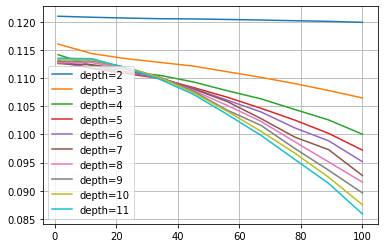

In [20]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

for i in range(scores.shape[0]):
    plt.plot(np.linspace(1, 100, 10), scores[i], label='depth=' + str(np.arange(2, 12)[i]))
plt.grid(True)
plt.legend()

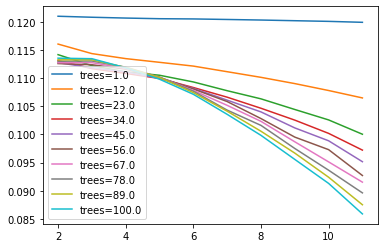

In [21]:
for i in range(scores.shape[1]):
    plt.plot(np.arange(2, 12), scores[i], label='trees=' + str(np.linspace(1, 100, 10)[i]))
plt.legend()

In [22]:
%%time

from sklearn.ensemble import RandomForestRegressor

linear_preds = RandomForestRegressor().fit(X_train, y_train).predict(X_test)
res5 = mean_squared_error(y_test, linear_preds) ** 0.5
print(res5)

0.05326896973572664
CPU times: user 6.53 s, sys: 749 µs, total: 6.53 s
Wall time: 6.53 s
